<a href="https://colab.research.google.com/github/jonathabsilva/TecImpIA/blob/main/Avaliacao1TAIA%5BAjustada%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Avaliação 1
Consideração o modelo de previsão de demanda, realizar a análise dos seguintes itens:

1. Modificar as funções de ativação utilizando Relu, Sigmod, tanh, etc. Analisar o desempenho da RNA. ✅

2. Modificar o número de camadas ocultas e neurônios (Sintonização da melhor rede) https://wandb.ai/site 

3. Realizar um estudo sobre o otimizador “Adam”

4. Na fase de teste, avaliar as métricas de:

  a. Erro Relativo Absoluto: |t-s|/t

  b. MAPE ✅

  c. Máximo Erro Relativo Absoluto: max(|t-s|)/t

5. Realizar a Previsão diária considerando um dia para frente e sete dias para atrás, com a finalidade de encontrar a melhor rede com ERA<10% e MAPE<3%. Utilize a 'Normalização' e faça a 'desnormalização' para mostrar os valores da previsão da potência. ✅

# Importação das Bibliotecas

Aqui, importa-se as seguintes bibliotecas:
1. tensorflow - 
2. pandas - 
3. numpy - 
4. matplotlib.pyplot - 



In [33]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
from math import floor 

# Biblioteca 

In [34]:
def Err_Rel_Abs(a,b):    
  from statistics import mean
  ERA = list()
  for i in range(len(a)):
    ERA.append(abs((a[i] - b[i])/a[i])[0])
  return ERA

In [35]:
def gera_camadas(n_min, n_max):
  camadas = list()
  for i in range(n_min,n_max):
    for j in range(n_min,n_max):
      camadas.append([i,j,1])
  return camadas

In [36]:
def str2list(string):
  string = string.split('[')[1]
  string = string.split(']')[0]
  string = string.split(', ')
  camada = list()
  for i in range(len(string)):
    camada.append(int(string[i]))

  return camada

# Leitura e Ajuste dos Dados

In [37]:
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
df = pd.read_csv('/content/drive/MyDrive/DESENVOLVIMENTO PESSOAL/MESTRADO/TÉCNICAS APLICADAS DE INTELIGÊNCIA ARTIFICIAL/Exemplo Previsão de Demanda/Parte 1 - Atualizado/dados_demanda.csv',delimiter=';')
df.dropna(axis=1,inplace=True)

df['TEMPO'] = df[['DIA','MES','ANO','HORA','MINUTO']].apply(lambda x : datetime(year=x[2],month=x[1],day=x[0],hour=x[3],minute=x[4]), axis=1)
df.drop(['MINUTO','HORA','ANO','DIA','MES'],axis=1,inplace=True)
df.rename(columns={'JPS_12B1':'POTENCIA'},inplace=True)
df['POTENCIA']=df['POTENCIA'].str.replace(',', '.').astype(float)
df.set_index('TEMPO',inplace=True)

In [39]:
maxima_semanal=df.resample('W').agg(['max'])

In [40]:
dias_atras = 7
dias_frente = 1

In [41]:
data = pd.DataFrame()
#data['POTÊNCIA'] = maxima_semanal

for i in range(dias_atras):
  data['POTÊNCIA(K-'+str(i)+')'] = maxima_semanal.shift(i)

for i in range(1,dias_frente+1):
  data['POTÊNCIA(K+'+str(i)+')'] = maxima_semanal.shift(-i)

In [42]:
data.dropna(axis=0, inplace=True)

In [43]:
fator_treino = 0.72
data_dim, len_data = data.shape #Pega a quantidade de dados. O segundo termo não é necessário, pois já se sabe a quantidade de colunas de treinamento e de saída. 
data_treino_dim = floor(data_dim*fator_treino)

len_train = dias_atras #Número de colunas usadas para treino

In [44]:
data = np.array(data)
data = tf.keras.utils.normalize(data,axis=1)

x_train = data[0:data_treino_dim,0:len_train]
y_train = data[0:data_treino_dim,len_train:len_data]

x_test = data[data_treino_dim:data_dim,0:len_train]
y_test = data[data_treino_dim:data_dim,len_train:len_data]

# Testes


In [45]:
y_train.shape

(221, 1)

# Questão 01

Modificar as funções de ativação utilizando Relu, Sigmod, tanh, etc. Analisar o desempenho da RNA.

In [46]:
funcoes = [tf.nn.relu, tf.nn.sigmoid, tf.nn.tanh, tf.nn.softmax]
medicoes = dict()
val_loss = dict()
val_mse = dict()

for funcao in funcoes:

  # Criando Rede
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Input(dias_atras))

  for i in [20,20,1]:
    model.add(tf.keras.layers.Dense(i,activation=funcao))

  # Parâmetros de treinamento
  model.compile(optimizer='adam',
                loss='mean_squared_error',
                metrics = ['mean_squared_error'])

  # Treinando 
  model.fit(x_train,y_train,epochs=1000)
  val_loss[funcao], val_mse[funcao] = model.evaluate(x_test,y_test)

melhor_funcao = list(val_mse.keys()) [list(val_mse.values()).index(min(val_mse.values()))]
melhor_funcao

A saída de streaming foi truncada nas últimas 5000 linhas.
Epoch 503/1000
7/7 [==============================] - 0s 3ms/step - loss: 3.2356e-04 - mean_squared_error: 3.2356e-04
Epoch 504/1000
7/7 [==============================] - 0s 3ms/step - loss: 3.2709e-04 - mean_squared_error: 3.2709e-04
Epoch 505/1000
7/7 [==============================] - 0s 3ms/step - loss: 3.1816e-04 - mean_squared_error: 3.1816e-04
Epoch 506/1000
7/7 [==============================] - 0s 3ms/step - loss: 3.1836e-04 - mean_squared_error: 3.1836e-04
Epoch 507/1000
7/7 [==============================] - 0s 3ms/step - loss: 3.2390e-04 - mean_squared_error: 3.2390e-04
Epoch 508/1000
7/7 [==============================] - 0s 3ms/step - loss: 3.2204e-04 - mean_squared_error: 3.2204e-04
Epoch 509/1000
7/7 [==============================] - 0s 3ms/step - loss: 3.1779e-04 - mean_squared_error: 3.1779e-04
Epoch 510/1000
7/7 [==============================] - 0s 3ms/step - loss: 3.2368e-04 - mean_squared_error: 3.2368e-

<function tensorflow.python.ops.gen_math_ops.tanh(x, name=None)>

In [47]:
val_loss

{<function tensorflow.python.ops.gen_nn_ops.relu(features, name=None)>: 0.00027392638730816543,
 <function tensorflow.python.ops.math_ops.sigmoid(x, name=None)>: 0.0002855113707482815,
 <function tensorflow.python.ops.gen_math_ops.tanh(x, name=None)>: 0.00023927575966808945,
 <function tensorflow.python.ops.nn_ops.softmax_v2(logits, axis=None, name=None)>: 0.4209577739238739}

# Questão 02

Modificar o número de camadas ocultas e neurônios (Sintonização da melhor rede)

In [48]:
medicoes = dict()
val_loss = dict()
val_mse = dict()

camadas = gera_camadas(3,33)

for camada in camadas:

  # Criando Rede
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Input(dias_atras))

  for i in camada:
    model.add(tf.keras.layers.Dense(i,activation=melhor_funcao))

  # Parâmetros de treinamento
  model.compile(optimizer='adam',
                loss='mean_squared_error',
                metrics = ['mean_squared_error'])

  # Treinando 
  model.fit(x_train,y_train,epochs=10)
  val_loss[str(camada)], val_mse[str(camada)] = model.evaluate(x_test,y_test)

melhor_camada = list(val_mse.keys()) [list(val_mse.values()).index(min(val_mse.values()))]

A saída de streaming foi truncada nas últimas 5000 linhas.
3/3 [==============================] - 0s 4ms/step - loss: 4.6304e-04 - mean_squared_error: 4.6304e-04
Epoch 1/10
7/7 [==============================] - 1s 3ms/step - loss: 0.0102 - mean_squared_error: 0.0102
Epoch 2/10
7/7 [==============================] - 0s 4ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 3/10
7/7 [==============================] - 0s 3ms/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 4/10
7/7 [==============================] - 0s 3ms/step - loss: 0.0015 - mean_squared_error: 0.0015    
Epoch 5/10
7/7 [==============================] - 0s 3ms/step - loss: 4.4490e-04 - mean_squared_error: 4.4490e-04
Epoch 6/10
7/7 [==============================] - 0s 4ms/step - loss: 6.6666e-04 - mean_squared_error: 6.6666e-04
Epoch 7/10
7/7 [==============================] - 0s 3ms/step - loss: 3.6094e-04 - mean_squared_error: 3.6094e-04
Epoch 8/10
7/7 [==============================] - 0s 3ms/step - loss

In [49]:
camada = str2list(melhor_camada)
camada 

[4, 13, 1]

# Questão 03
Realizar um estudo sobre o otimizador “Adam”

#Questão 4
 Na fase de teste, avaliar as métricas de:

  a. Erro Relativo Absoluto: |t-s|/t

  b. MAPE 

  c. Máximo Erro Relativo Absoluto: max(|t-s|)/t 

## a. Erro Relativo Absoluto

 |t-s|/t

In [57]:
y_pred = model.predict(x_test)
Err_Rel_Abs(y_test, y_pred)

[0.0014548742575301267,
 0.0014263141281431694,
 0.0009221801175312137,
 0.0003260034299701471,
 0.010256554539562594,
 0.00425550526414921,
 0.00722154695243721,
 0.004361422647544699,
 0.0038667250017249276,
 0.005678056405547621,
 0.005328062426746458,
 0.0018334974610652575,
 0.0008003547203618605,
 0.0022024777820253676,
 0.001427821100736317,
 0.0017873661361956154,
 0.0004584705810689436,
 0.001378828730831134,
 0.0009951015077054538,
 0.0008467467228411707,
 0.0027652834006193145,
 0.002046017229234585,
 0.0015278046002996926,
 0.005164584549950454,
 0.002997786539398971,
 0.005925655210474478,
 0.006062674908861557,
 0.0034213553789631678,
 4.6873820565366364e-05,
 0.0018878417562636022,
 0.0011723765376701863,
 0.004988444593397968,
 0.009942329446488202,
 0.00950588837905939,
 0.005043513443004995,
 0.006606997428959148,
 0.0073077189714285395,
 0.005097070320242901,
 0.008929821344913418,
 0.012849258313127304,
 0.005715159358165098,
 0.000213087766253047,
 0.00030549879443

  ## b. MAPE 

In [58]:
MAPE = mean_absolute_percentage_error(y_test, y_pred)
MAPE 


0.004355722342070853

## c. Máximo Erro Relativo Absoluto: max(|t-s|)/t 

In [59]:
max(Err_Rel_Abs(y_test, y_pred))

0.04229348201471317

# Questão 05
Realizar a Previsão diária considerando um dia para frente e sete dias para atrás, com a finalidade de encontrar a melhor rede com ERA<10% e MAPE<3%. Utilize a 'Normalização' e faça a 'desnormalização' para mostrar os valores da previsão da potência.


## Treinamento

In [53]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(dias_atras))
for i in camada:
  model.add(tf.keras.layers.Dense(i,activation=melhor_funcao))

# Parâmetros de treinamento
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics = ['mean_squared_error'])

# Treinando 
model.fit(x_train,y_train,epochs=5000)
loss, mse = model.evaluate(x_test,y_test)


A saída de streaming foi truncada nas últimas 5000 linhas.
Epoch 2502/5000
7/7 [==============================] - 0s 3ms/step - loss: 7.8244e-05 - mean_squared_error: 7.8244e-05
Epoch 2503/5000
7/7 [==============================] - 0s 3ms/step - loss: 9.2685e-05 - mean_squared_error: 9.2685e-05
Epoch 2504/5000
7/7 [==============================] - 0s 3ms/step - loss: 8.9526e-05 - mean_squared_error: 8.9526e-05
Epoch 2505/5000
7/7 [==============================] - 0s 3ms/step - loss: 8.1116e-05 - mean_squared_error: 8.1116e-05
Epoch 2506/5000
7/7 [==============================] - 0s 3ms/step - loss: 8.1493e-05 - mean_squared_error: 8.1493e-05
Epoch 2507/5000
7/7 [==============================] - 0s 3ms/step - loss: 8.8195e-05 - mean_squared_error: 8.8195e-05
Epoch 2508/5000
7/7 [==============================] - 0s 2ms/step - loss: 9.5290e-05 - mean_squared_error: 9.5290e-05
Epoch 2509/5000
7/7 [==============================] - 0s 3ms/step - loss: 9.3884e-05 - mean_squared_error: 

## Examinando o desempenho da rede

In [54]:
maximo = np.array(maxima_semanal.agg(['max']))[0][0]

3/3 [==============================] - 0s 3ms/step - loss: 4.8086e-06 - mean_squared_error: 4.8086e-06


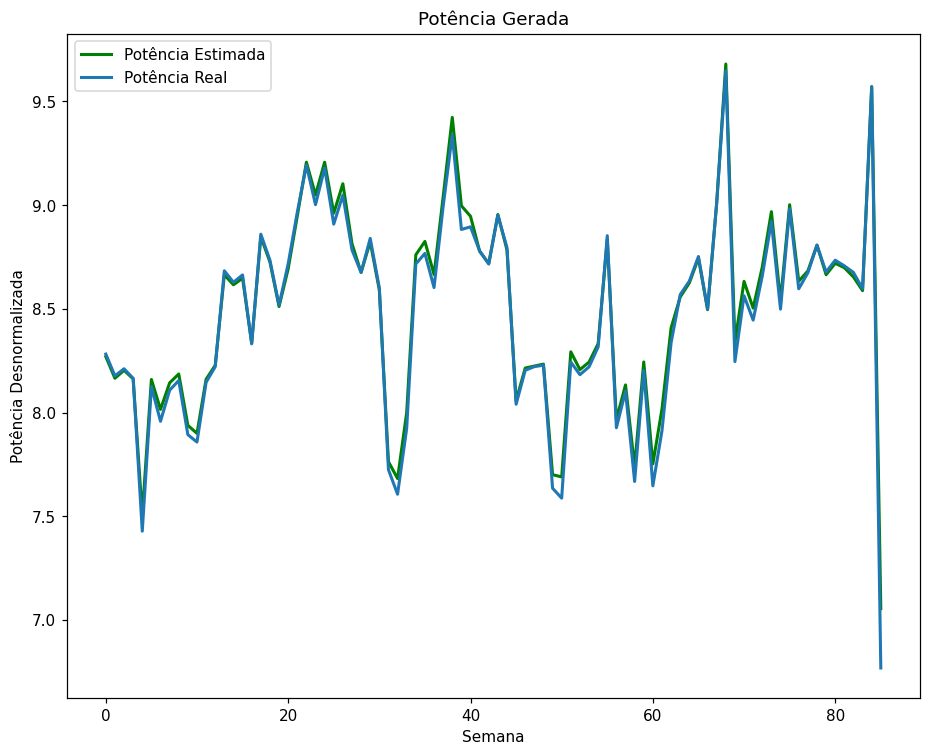

In [55]:
val_loss, val_mse = model.evaluate(x_test,y_test)
y_pred = model.predict(x_test)

plt.figure(figsize=(10,8),dpi=110)
plt.plot(y_pred[:,0]*maximo,lw=2,color='Green')
plt.plot(y_test[:,0]*maximo,lw=2)

plt.title('Potência Gerada')
plt.xlabel('Semana')
plt.ylabel('Potência Desnormalizada')
plt.legend(['Potência Estimada','Potência Real']) 

In [56]:
MAPE = mean_absolute_percentage_error(y_test, y_pred)
ERA = max(Err_Rel_Abs(y_test, y_pred))

print('MAPE: '+str(MAPE*100)+'%')
print('ERA: '+str(ERA*100)+'%')

if (MAPE*100 < 3) and (ERA*100 < 10):
  print('\nCondições atendidas!')
else:
  print('\nCondições não atendidas.')

MAPE: 0.4355722342070853%
ERA: 4.229348201471317%

Condições atendidas!
